In [1]:
import re
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
plt.style.use('ggplot')
%matplotlib inline
pd.set_option('display.max_rows', 400) # показывать больше строк
pd.set_option('display.max_columns', 30) # по

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

    Restaurant_id — идентификационный номер ресторана / сети ресторанов;
    City — город, в котором находится ресторан;
    Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
    Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
    Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
    Price Range — диапазон цен в ресторане;
    Number of Reviews — количество отзывов о ресторане;
    Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
    URL_TA — URL страницы ресторана на TripAdvosor;
    ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [4]:
df = pd.read_csv('main_task.csv')

In [5]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


приводим названия колонок к одному виду

In [7]:
df.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking', 'rating','price_range', 'n_reviews', 'reviews', 'url_ta', 'id_ta']

проверяем количество уникальных id рестаранов

In [8]:
def str_to_arr(string):
    if pd.isna(string):
        return
    arr = []
    arr_temp = np.array([])
    if string[0] == '[' and string[-1] == ']':
        string = string[1:-1]
        arr_temp = np.array(string.split(', '))
    for a in arr_temp:
        a = a.replace("'", '')
        arr.append(a)
    arr = np.array(arr)
    return arr
df.cuisine_style = df.cuisine_style.apply(str_to_arr)

In [9]:
df.cuisine_style = df.cuisine_style.fillna('n')

In [10]:
citchen_wariable_arr = []
def citchen_wariable(arr):
    for i in arr:
        if i != 'n':
            if i not in citchen_wariable_arr:
                citchen_wariable_arr.append(i)
df.cuisine_style.apply(citchen_wariable)
citchen_wariable_arr.sort()
len(citchen_wariable_arr)

125

In [11]:
for i in citchen_wariable_arr:
    i = i.replace(' ','_')
    df['citchen_{0}'.format(i)] = 0
    
for i in df.index:
    citchen = df.loc[i].cuisine_style
    if type(citchen) != 'str':
        for j in citchen:
            j = j.replace(' ', '_')
            df.loc[i, 'citchen_{0}'.format(j)] = 1

count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: ranking, dtype: float64

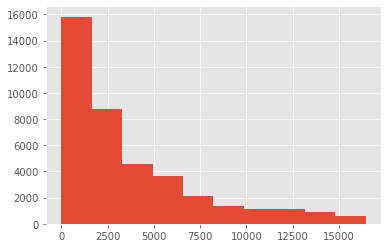

In [12]:
df.ranking.hist()
df.ranking.describe()


count      40000
unique        31
top       London
freq        5757
Name: city, dtype: object

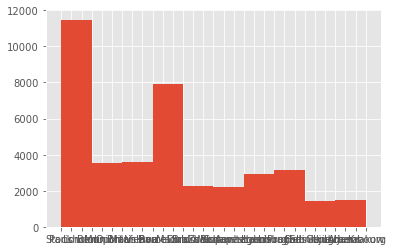

In [13]:
df.city.hist()
df.city.describe()

In [14]:
df = pd.get_dummies(df, columns=[ 'city',], dummy_na=True)

In [15]:
df.price_range.describe()

count        26114
unique           3
top       $$ - $$$
freq         18412
Name: price_range, dtype: object

In [16]:
df.price_range = df.price_range.fillna(df.price_range.mode()[0])

In [17]:
price_range = {'$$ - $$$' : 1, '$': 0, '$$$$':2}
df.price_range = df.price_range.map(price_range)
df = pd.get_dummies(df, columns=[ 'price_range',], dummy_na=True)

count    37457.000000
mean       124.825480
std        295.666352
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: n_reviews, dtype: float64

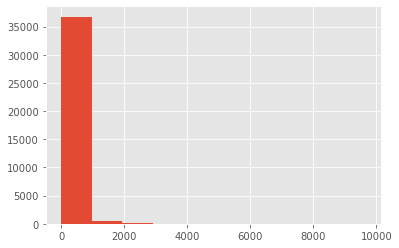

In [19]:
df.n_reviews.hist()
df.n_reviews.describe()

In [20]:
df.n_reviews = df.n_reviews.fillna(0)

In [21]:
df.n_reviews.value_counts().sort_index()

0.0       2543
2.0       1916
3.0       1636
4.0       1370
5.0       1181
          ... 
6777.0       1
7575.0       1
7622.0       1
8927.0       1
9660.0       1
Name: n_reviews, Length: 1460, dtype: int64

25-й перцентиль: 7.0, 75-й перцентиль: 105.0, IQR: 98.0,  Границы выбросов: [0, 252.0].


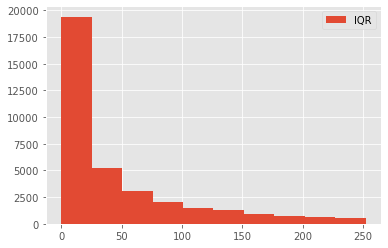

In [22]:
median = df.n_reviews.median()
IQR = df.n_reviews.quantile(0.75) - df.n_reviews.quantile(0.25)
perc25 = df.n_reviews.quantile(0.25)
perc75 = df.n_reviews.quantile(0.75)
#min = 0
perc25_new = 0
perc75_new = perc75 + 1.5*IQR
temp_absences_mean = df.n_reviews.mean()
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {i}].".format(f=perc25_new, i = perc75_new))
df.n_reviews.loc[df.n_reviews.between(perc25_new, perc75_new)].hist(bins = 10, range = (0, perc75_new), 
                                                                                             label = 'IQR')
plt.legend();

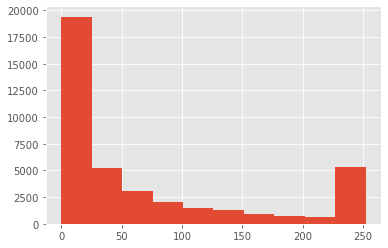

In [23]:
df.n_reviews = df.n_reviews.apply(lambda x: x if x < 252 else 252)
df.n_reviews.hist()

In [24]:
df.reviews.describe()

count        40000
unique       33516
top       [[], []]
freq          6471
Name: reviews, dtype: object

In [25]:
df.reviews[0]

"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]"

In [26]:
df['dates'] = df.reviews.apply(lambda x: x[2:-2].split("], [")[1])

In [27]:
df['date_1'] = df['dates'].apply(lambda x: x if x == '' else datetime.strptime(x.split(',')[0].replace("'",''), '%m/%d/%Y'))
df['date_1'] 

0       2017-12-31
1       2017-07-06
2       2018-01-08
3              NaT
4       2017-11-18
           ...    
39995   2017-12-16
39996   2017-12-21
39997   2016-11-03
39998   2017-07-11
39999   2016-01-31
Name: date_1, Length: 40000, dtype: datetime64[ns]

In [28]:
def date_2(x):
    if x == '':
        return x
    elif len(x.split(',')) > 1:
        return datetime.strptime(x.split(',')[1].replace("'",'').replace(' ',''), '%m/%d/%Y')
    else: 
        return ''
df['date_2'] = df['dates'].apply(date_2)
df['date_2'] 

0       2017-11-20
1       2016-06-19
2       2018-01-06
3              NaT
4       2017-02-19
           ...    
39995   2017-11-12
39996   2017-12-12
39997   2008-04-12
39998   2017-06-18
39999   2012-07-04
Name: date_2, Length: 40000, dtype: datetime64[ns]

In [29]:
df['date_delta'] = df['date_1'] - df['date_2'] 

In [30]:
df['date_delta']

0         41 days
1        382 days
2          2 days
3             NaT
4        272 days
           ...   
39995     34 days
39996      9 days
39997   3127 days
39998     23 days
39999   1306 days
Name: date_delta, Length: 40000, dtype: timedelta64[ns]

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 174 entries, restaurant_id to date_delta
dtypes: datetime64[ns](2), float64(4), int64(125), object(6), timedelta64[ns](1), uint8(36)
memory usage: 43.5+ MB


In [32]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [44]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
X = df.drop(['restaurant_id', 'rating','cuisine_style','reviews','url_ta','id_ta', 'dates'], axis = 1)  
y = df['rating']  
  
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
  
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)  

In [49]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
  
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
  
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

TypeError: invalid type promotion